In [ ]:
#  This is a rudimentary SIR model roughly fit against the current cases 
#  without further assumptions which would represent a "worse case scenario"

In [17]:
!pip3 install bokeh
import json
import requests
import pandas as pds
import numpy as np
import math
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')

In [39]:
#  Current corona data
response = requests.get("https://covidtracking.com/api/us/daily")
data = response.json()
df = pd.DataFrame(data=data)
df['date_stamp']  = pd.to_datetime(df['date'], format='%Y%m%d')
df['starting_date'] = pd.to_datetime("20200304", format='%Y%m%d')
df['day'] = (df['date_stamp'] - df['starting_date']).dt.days

In [40]:
df

,date,states,positive,negative,posNeg,pending,hospitalized,death,total,date_stamp,starting_date,day
0,20200323,56,42164,237321,279485,14571,3325.0,471.0,294056,2020-03-23,2020-03-04,19
1,20200322,56,31888,193463,225351,2842,2554.0,398.0,228216,2020-03-22,2020-03-04,18
2,20200321,56,23203,155909,179112,3477,1964.0,272.0,182589,2020-03-21,2020-03-04,17
3,20200320,56,17038,118147,135185,3336,NaN,219.0,138521,2020-03-20,2020-03-04,16
4,20200319,56,11723,89119,100842,3025,NaN,160.0,103867,2020-03-19,2020-03-04,15
5,20200318,56,7731,66225,73956,2538,NaN,112.0,76495,2020-03-18,2020-03-04,14
6,20200317,56,5723,47604,53327,1687,NaN,90.0,54957,2020-03-17,2020-03-04,13
7,20200316,56,4019,36104,40123,1691,NaN,71.0,41714,2020-03-16,2020-03-04,12
8,20200315,51,3173,22548,25721,2242,NaN,60.0,27963,2020-03-15,2020-03-04,11
9,20200314,51,2450,17102,19552,1236,NaN,49.0,20789,2020-03-14,2020-03-04,10


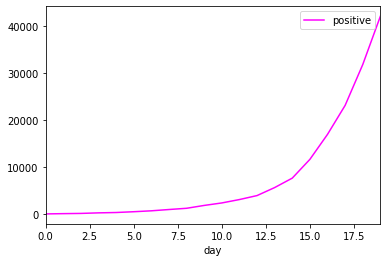

In [41]:
df.plot(x ='day', y='positive', color='magenta')

In [99]:
def plot(total_pop, starting_infected, xlim, ylim, beta, r0=2.2, g=1./8):
    # Total population, N.  US population
    N = 327200000
    # Initial number of infected and recovered individuals, I0 and R0.
    # R0 Assumed to be 2.2 for coronavirus
    I0, R0 = starting_infected, r0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma = beta, g
    # A grid of time points (in days)
    t = np.linspace(0, xlim, xlim)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I, 'magenta', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, I * 0.10, 'r', alpha=0.5, lw=2, label='Hospitalized')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')    
    ax.axhline(y= N * 0.7, linestyle='--', label='Herd Immunity Point')
    ax.plot(t, I*0.034, "black", alpha=1, lw=2, label='Death Rate')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number')
    ax.set_ylim(0,ylim)
    ax.set_xlim(0,xlim)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return fig, ax

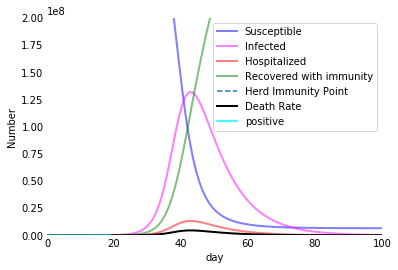

In [104]:
#  Rudimentary fitting by tweaking beta parameter
#  on 1st day had starting infected of 118 and in 17 days had 20000
fig, ax = plot(327200000, 118, 100, 200000000, 0.5)
df.plot(x ='day', y='positive', color='cyan', ax=ax)
fig.show()

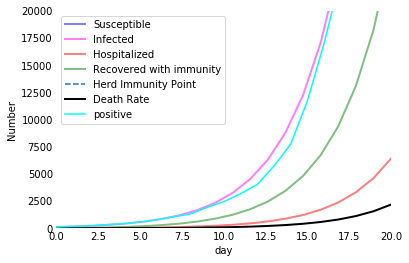

In [160]:
estimated_beta = 0.44
fig, ax = plot(327200000, 118, 20, 20000, estimated_beta)
df.plot(x ='day', y='positive', color='cyan', ax=ax)
fig.show()

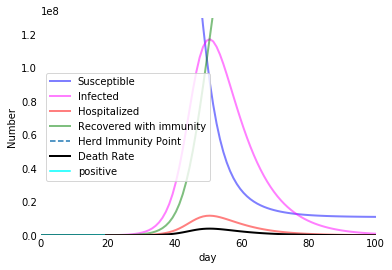

In [161]:
#  Finer tuned fitting by tweaking beta parameter to current data
#  on 1st day had starting infected of 118 and in 17 days had 20000
fig, ax = plot(327200000, 118, 100, 130000000, estimated_beta)
df.plot(x ='day', y='positive', color='cyan', ax=ax)
fig.show()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152871cad0>)

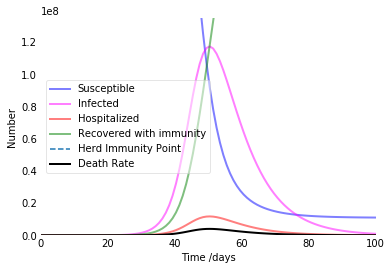

In [162]:
#  At our current trajectory a standard SIR model predicts peak 120 million infected
plot(327200000, 118, 100, ( 1.35* 10**8), estimated_beta)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152871cd50>)

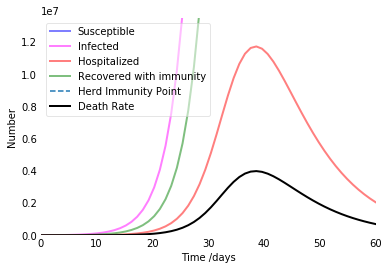

In [164]:
#  With about 12 milion hospitalizations
plot(327200000, 5000, 60,13500000, estimated_beta)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15286b3650>)

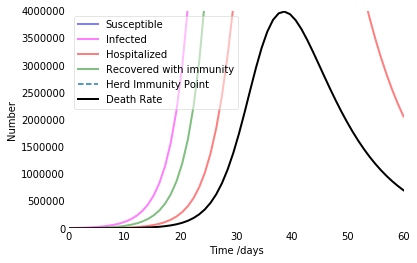

In [171]:
#  And about 4 milion deaths
plot(327200000, 5000, 60,4000000, estimated_beta)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x152bb45ad0>)

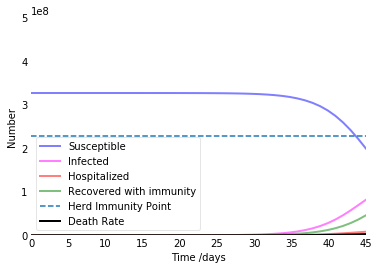

In [176]:
#  Reaching herd immunity at about day 44
plot(327200000, 118, 45, ( 5* 10**8), estimated_beta)

In [ ]:
# For comparison standard flu season CDC estimates 35.5 million illnesses, 
# more than 16.5 million medical visits, 4
# 490,600 hospitalizations, and 
# 34,200 deaths


#  The beta parameter (0.5) in the above is the contact parameter.  This is combination of the infectiousness of the
#  disease and the contact that individuals have (quarantine affects this)
#  If our efforts decrease the beta to 0.4 it increases the period of the disease by about 10 days
#  And decreases max infected to about 108 million

plot(327200000, 118, 68, ( 3* 10**8), 0.4)
plot(327200000, 118, 100, ( 1.1* 10**8), 0.4)

In [ ]:
# Hospitalizations go down to 11 million
plot(327200000, 5000, 60,11000000, 0.4)

In [ ]:
#  The main concern is not overwhelming the hospital system, which has about 1 million beds by most estimates.
# This means we would have to stay around 7,700,000 total infected (7.7 million * 0.13 hospitalization rate = 1 million)
# This would require a beta of 0.31
plot(327200000, 5000, 200,7700000, 0.31)

In [ ]:
#  Its questionable we can affect the beta this much but assuming social distancing does then that would push the
#  herd immunity of the disease out to 78 days almost 2 2/3 months
plot(327200000, 5000, 78,300000000, 0.31)

In [ ]:
# Korea went from 578 cases to 5498 cases in 10 days, therefore their beta is estimated to be 0.35
plot(51470000, 578,10,5498, 0.35)

In [ ]:
# According to this S. Korea (even with their lower beta accounting for their government response) should have peaked
# at 9 million infections.  But they peaked at 8,000 infections.
plot(51470000, 578, 100, 9000000, 0.35, 2.2)


In [ ]:
# In order to get peak at 8,000 infections beta has to be 0.1258
# But this places the temporal location of the peak faaar into the future
# This means a couple of things:
# 1.  The initial infectious population needs to be modelling by 
#  splitting this into two phases according to changes in policy before they tamped down.
# 2.  Gamma is not accurate.
plot(51470000, 578, 5000, 8000, 0.1258, 2.2)

In [ ]:
# Changing gamma and beta and R0 until we have a peak at 28 days at 8,000 infections as observed in the data
from matplotlib.widgets import Slider

plot(51470000, 578, 1000, 8000, 0.2, 2.2, 1./10)